In [1]:
# Dependence of Sumbarine Melt (Qsm) on Temp and Strat
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
### Variables for scaling Qsm
Qsg = 250 # Subglacial discharge
N = 20 # Number of data points
# Thermal forcing
T0 = 0 # Freezing temp of seawater
Tice = np.linspace(0, 12, N)
#Tice = np.linspace(8, 11, N)
TF = Tice - T0

# Stratification
Rhoz = np.linspace(5, 10, N) # Depth averaged density gradient
#Strat1 = np.sqrt(Rhoz)
Nsquare = np.linspace(2e-5, 3e-4, N) # Buoyancy frequency
#Strat2 = (Nsquare)**(5/8)

# Submarine melt
[Rhoz_mesh, TF_mesh1] = np.meshgrid(Rhoz, TF)
Qsm1 = TF_mesh1 / np.sqrt(Rhoz_mesh) # Scaling by (Magorrian & Wells, 2016)

[N2_mesh, TF_mesh2] = np.meshgrid(Nsquare, TF)
Qsm2 = TF_mesh2 / ((N2_mesh)**(5/8)) # Scaling by (Slater et al., 2016)

In [45]:
#np.linspace(3e-5, 3e-4, 15)
Qsm2

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [  546.11473901,   386.75299539,   310.05856819,   263.43516781,
          231.52164994,   208.03487403,   189.88105365,   175.34312195,
          163.38430634,   153.33803622,   144.75437405,   137.31756193,
          130.79884057,   125.02802258,   119.87561851,   115.24118674,
          111.04550345,   107.22515836,   103.72873739,   100.5140705 ],
       [ 1092.22947802,   773.50599077,   620.11713639,   526.87033562,
          463.04329987,   416.06974807,   379.76210731,   350.68624389,
          326.76861267,   306.67607244,   289.5087481 ,   274.63512387,
          261.59768114,   250.05604516,   239.75123701,   230.

In [3]:
# Obtain submarine melting Qsm
def IFA(datapath, case_id):
    # Grid areas
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200
    file0 = xr.open_dataset(datapath+'/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    file = file0.isel(T=~file0.get_index("T").duplicated()) 
    t0 = 89
    tn = len(file.T)
    state = file.isel(Y=range(35,45), T=range(t0,tn))
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [4]:
def Qsm_depend(datapath, case_id):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(1,len(State.T)))
    
    depth = state.Z.data
    time = state.T.data / 86400 # Time in days
    
    xid = 1
    # Potential temp
    Ttz = state.Temp.data[:,:,:,xid].mean(2) # Temp

    # Pressure and Density
    pres = gsw.p_from_z(depth, 55)
    Stz = state.S.data[:,:,:,xid].mean(2)
    p = np.tile(pres,[len(time),1])
    Rho = gsw.rho(Stz, Ttz, p)
    
    N2, Pmid = gsw.Nsquared(Stz,Ttz,pres,55,axis=1)
    
    
    # Grid areas    
    Area = np.empty(90)
    Area[:20] = 400
    Area[20:50] = 800
    Area[50:] = 1200

    file0 = xr.open_dataset(datapath + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    ip_state = file.isel(Y=range(35,45))
    
    MR = ip_state.icefrntA.isel(X=1).data.mean(2) # Melt rate at the icefront
    Qsm = (MR*Area*10) / (24*3600)
    
    return Ttz, N2

In [5]:
# Compare shallow- and no-sill cases
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill'

case = np.array([1,2,3,4,5])
T10_ss = np.ones(len(case)) * np.nan
N2T10_ss = np.ones(len(case)) * np.nan
T10_ns = np.ones(len(case)) * np.nan
N2T10_ns = np.ones(len(case)) * np.nan

ti, zi = 89, -10
for i in range(len(case)):
    T1, N1 = Qsm_depend(path1, case[i])
    #T_ss[i] = T1[]
    
    T2, N2 = Qsm_depend(path2, case[i])
    N2T10_ns[i] = N2[ti:,:zi].mean()
    #N2_ss[i] = N1[ti:,:zi].mean()
    #T_ns[i] = T2[]
    if i < 2:
        N2T10_ss[i] = N1[ti:,:zi].mean() # Shallow-sill values are sensitive to zi
        #N2_ns[i] = N2[ti:,:zi].mean()
    else:
        N2T10_ss[i] = N1[ti:,:].mean()
        #N2_ns[i] = N2[ti:,:].mean()

# Various inital temp cases
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill_Tini6'
path4 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_sill_Tini6'
path5 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill_Tini2'
path6 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_sill_Tini2'

T6_ns = np.ones(len(case)) * np.nan
N2T6_ns = np.ones(len(case)) * np.nan
T6_ss = np.ones(len(case)) * np.nan
N2T6_ss = np.ones(len(case)) * np.nan
QsmT6_ns = np.ones(len(case)) * np.nan
QsmT6_ss = np.ones(len(case)) * np.nan

T2_ns = np.ones(len(case)) * np.nan
N2T2_ns = np.ones(len(case)) * np.nan
T2_ss = np.ones(len(case)) * np.nan
N2T2_ss = np.ones(len(case)) * np.nan
QsmT2_ns = np.ones(len(case)) * np.nan
QsmT2_ss = np.ones(len(case)) * np.nan

for i in range(len(case)):
    T3, N3 = Qsm_depend(path3, case[i])
    T6_ns[i] = T3[ti:,:zi].mean()
    N2T6_ns[i] = N3[ti:,:zi].mean()
    
    T4, N4 = Qsm_depend(path4, case[i])
    T6_ss[i] = T4[ti:,:zi].mean()
    N2T6_ss[i] = N4[ti:,:zi].mean()
    
    T5, N5 = Qsm_depend(path5, case[i])
    T2_ns[i] = T5[ti:,:zi].mean()
    N2T2_ns[i] = N5[ti:,:zi].mean()
    
    T6, N6 = Qsm_depend(path6, case[i])
    T2_ss[i] = T6[ti:,:zi].mean()
    N2T2_ss[i] = N6[ti:,:zi].mean()

    QsmT6_ns[i] = IFA(path3, case[i])
    QsmT6_ss[i] = IFA(path4, case[i])

    QsmT2_ns[i] = IFA(path5, case[i])
    QsmT2_ss[i] = IFA(path6, case[i])   

In [8]:
np.array([3.68, 7.36, 14.72, 22.08, 29.44])*1e-5

array([3.680e-05, 7.360e-05, 1.472e-04, 2.208e-04, 2.944e-04])

In [9]:
# Saved model outputs
QsmT10_ss = np.array([5.98981555, 6.10563305, 6.85205652, 8.87824692, 9.58235464])
QsmT10_ns = np.array([5.11334446, 5.57730199, 6.42534292, 7.81707443, 8.58837926])
T10_ss = np.array([8.87177824, 8.99560188, 8.93084422, 9.09636703, 9.28237592])
T10_ns = np.array([9.88115542, 9.88382674, 9.88802081, 9.86293875, 9.88767712])

In [10]:
parameter_ds = xr.Dataset(
    data_vars={'N2_ini' : np.array([3.68, 7.36, 14.72, 22.08, 29.44])*1e-5,
    'N2T10_ns' : N2T10_ns,
    'N2T10_ss' : N2T10_ss,
    'N2T6_ns' : N2T6_ns,
    'N2T6_ss' : N2T6_ss,
    'N2T2_ns' : N2T2_ns,
    'N2T2_ss' : N2T2_ss,
    'T10_ns' : T10_ns,
    'T10_ss' : T10_ss,
    'T6_ns' : T6_ns,
    'T6_ss' : T6_ss,
    'T2_ns' : T2_ns,
    'T2_ss' : T2_ss,
    'QsmT10_ns' : QsmT10_ns,
    'QsmT10_ss' : QsmT10_ss,
    'QsmT6_ns' : QsmT6_ns,
    'QsmT6_ss' : QsmT6_ss,
    'QsmT2_ns' : QsmT2_ns,
    'QsmT2_ss' : QsmT2_ss})

outdir = "/home/1959/Parameters/FjordModeling/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

parameter_ds.to_netcdf(outdir + 'Qsm_N2_T_depend.nc')

In [4]:
# Load dataset
DS = xr.open_dataset('~/Parameters/FjordModeling/Qsm_N2_T_depend.nc')

N2T10_ns = DS.N2T10_ns.data
N2T10_ss = DS.N2T10_ss.data
N2T6_ns = DS.N2T6_ns.data
N2T6_ss = DS.N2T6_ss.data
N2T2_ns = DS.N2T2_ns.data
N2T2_ss = DS.N2T2_ss.data

T10_ns = DS.T10_ns.data
T10_ss = DS.T10_ss.data
T6_ns = DS.T6_ns.data
T6_ss = DS.T6_ss.data
T2_ns = DS.T2_ns.data
T2_ss = DS.T2_ss.data

QsmT10_ns = DS.QsmT10_ns.data
QsmT10_ss = DS.QsmT10_ss.data
QsmT6_ns = DS.QsmT6_ns.data
QsmT6_ss = DS.QsmT6_ss.data
QsmT2_ns = DS.QsmT2_ns.data
QsmT2_ss = DS.QsmT2_ss.data

In [5]:
N2T10_mod = N2T10_ss.copy()
N2T10_mod[-3:] = N2T10_mod[-3:]/2
# N2T6_mod = N2T6_ss.copy()
# N2T6_mod[-2:] = N2T6_mod[-2:]/2
# N2T2_mod = N2T2_ss.copy()
# N2T2_mod[-2:] = N2T2_mod[-2:]/2

In [101]:
N2T10_mod, N2T10_ss

(array([2.43774989e-04, 1.18638056e-04, 5.16657407e-05, 3.73982767e-05,
        2.94744407e-05]),
 array([2.43774989e-04, 1.18638056e-04, 1.03331481e-04, 7.47965535e-05,
        5.89488814e-05]))

NameError: name 'Qsm_ss' is not defined

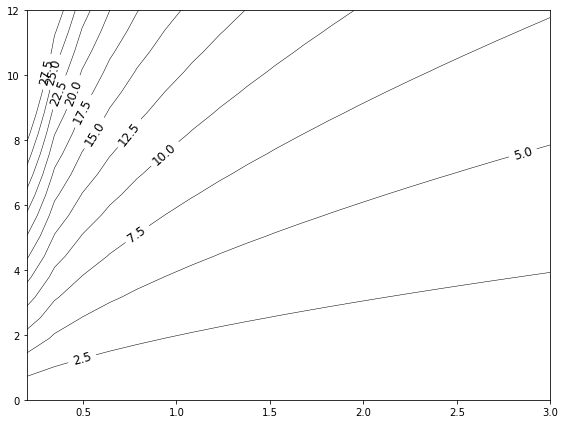

In [11]:
fig0, ax0 =plt.subplots(figsize=(8,6))
fig0.tight_layout() 

import matplotlib as mpl
cmap = mpl.cm.viridis
bounds = np.linspace(2,10,20)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

cqsm = np.arange(2.5,30,2.5)
cs = ax0.contour(Nsquare*1e4,TF,Qsm2/Qsg,cqsm,colors='k',linewidths=.5)
plt.clabel(cs, fmt='%1.1f', fontsize=12, inline=1)

# Marker size in units of points^2
volume1 = (10 * Qsm_ss / Qsm_ss[0])**2
volume2 = (10 * Qsm_ns / Qsm_ns[0])**2
volume3 = (10 * Qsm_maxq / Qsm_maxq[0])**2
volume4 = (10 * Qsm_minq / Qsm_minq[0])**2
volume = np.linspace(1,5,5)*15


Qsm = np.concatenate([Qsm_ss, Qsm_ns, Qsm_maxq[:-1], Qsm_minq[:-1]], axis=0)
min_, max_ = Qsm.min(), Qsm.max()

plt.scatter(N2_ns*1e4,T_ns,s=500, c=Qsm_ns, cmap=cmap, 
            norm=norm, alpha=0.7, label='$h_s/h_f=1$')
plt.clim(min_, max_)
plt.scatter(N2_mod*1e4,T_ss,s=100, c=Qsm_ss, cmap=cmap,
            norm=norm, alpha=0.7, label='$h_s/h_f=0.04$')
plt.clim(min_, max_)

plt.annotate('$0.5N^2_0\sim4N^2_0$', xy=(2.5,11), xytext=(1.2,10.9),
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)


plt.scatter(N2_maxq[:-1]*1e4,T_maxq[:-1],s=500, 
            c=Qsm_maxq[:-1], cmap=cmap,
            norm=norm, marker='^', 
            alpha=0.7, 
            label='$Q_{sg}=500\,m^3\,s^{-1}$')
plt.clim(min_, max_)

plt.scatter(N2_minq[:-1]*1e4,T_minq[:-1],s=100, 
            c=Qsm_minq[:-1], cmap=cmap,
            norm=norm, marker='^', 
            alpha=0.7, 
            label='$Q_{sg}=50\,m^3\,s^{-1}$')
plt.clim(min_, max_)

plt.annotate('$T_{ini}=2\sim8^\circ C$', xy=(.9,6), xytext=(.9,1),
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)

plt.legend(loc='best', fontsize=15)



cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks([2,4,6,8,10])
cbar.set_label('$Q_{sm}\,[m^3\,s^{-1}]$', fontsize=15)
# cbaxes1 = fig0.add_axes([0.95, 0.5, 0.05, 0.5])
# cbar1 = fig0.colorbar(im1,cax=cbaxes1, orientation='vertical')
# cbar1.set_ticks([0, 4, 8, 12])
# cbar1.ax.set_title('$Q_{sm}$ [$m^3\,s^{-1}$]', size=15)
#ax0.set(xlim=(0, 3), ylim=(0, 12))
plt.tick_params(direction='in', labelsize=15)
#ax0.set_title('Filled Contour Plot')
plt.ylabel(r'$T-T_0$ [$^\circ C$]', size=15)
plt.xlabel(r'$N^2$ [$\times10^{-4}\,s^{-2}$]', size=15)


Text(0.5, 33.0, '$N^2$ [$\\times10^{-4}\\,s^{-2}$]')

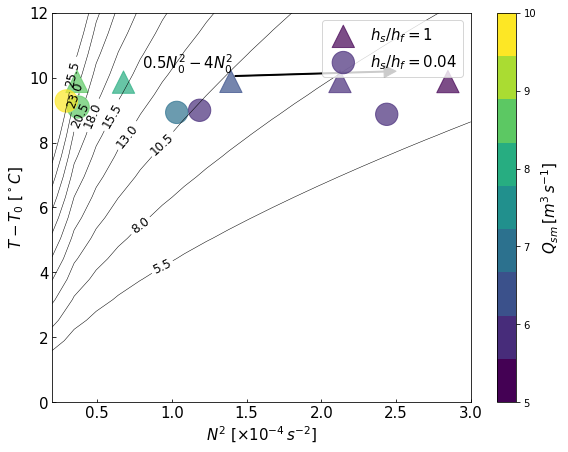

In [13]:
fig1, ax0 =plt.subplots(figsize=(8,6))
fig1.tight_layout() 

import matplotlib as mpl
cmap = mpl.cm.viridis
bounds = np.linspace(5,10,10)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cqsm = np.arange(5.5,27.5,2.5)
cs = ax0.contour(Nsquare*1e4,TF,Qsm2/Qsg,cqsm,colors='k',linewidths=.5)
plt.clabel(cs, fmt='%1.1f', fontsize=12, inline=1)

# Marker size in units of points^2
volume1 = (10 * QsmT10_ss / QsmT10_ss[0])**2
volume2 = (10 * QsmT10_ns / QsmT10_ns[0])**2
volume = np.linspace(1,5,5)*15


#Qsm = np.concatenate([Qsm_ss, Qsm_ns, Qsm_maxq[:-1], Qsm_minq[:-1]], axis=0)
Qsm = np.concatenate([QsmT10_ss, QsmT10_ns], axis=0)
min_, max_ = Qsm.min(), Qsm.max()

plt.scatter(N2T10_ns*1e4,T10_ns,s=500, c=QsmT10_ns, cmap=cmap, marker='^',
            norm=norm, alpha=0.7, label='$h_s/h_f=1$')
plt.clim(min_, max_)
plt.scatter(N2T10_mod*1e4,T10_ss,s=500, c=QsmT10_ss, cmap=cmap, marker='o',
            norm=norm, alpha=0.7, label='$h_s/h_f=0.04$')
plt.clim(min_, max_)

plt.annotate('$0.5N^2_0-4N^2_0$', xy=(2.5,10.2), xytext=(.8,10.25),
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)

plt.legend(loc='best', fontsize=15)

#plt.ylim([8,11])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks([5,6,7,8,9,10])
cbar.set_label('$Q_{sm}\,[m^3\,s^{-1}]$', fontsize=15)
plt.tick_params(direction='in', labelsize=15)
plt.ylabel(r'$T-T_0$ [$^\circ C$]', size=15)
plt.xlabel(r'$N^2$ [$\times10^{-4}\,s^{-2}$]', size=15)


In [6]:
Qsm = np.concatenate([QsmT10_ss[:-1], QsmT10_ns[:-1], QsmT6_ss[:-1], QsmT6_ns[:-1], QsmT2_ss[:-1], QsmT2_ns[:-1]], axis=0)
min_, max_ = Qsm.min(), Qsm.max()
min_, max_

(1.4461061269803732, 8.87824692)

In [42]:
Qs1, Qs2 = Qsm2/(Qsg**(1/3)), Qsm2/Qsg
Qs1.max(), Qs1.min(), Qs2.max(), Qs2.min()
np.linspace(5,95,10)

array([ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.])

Text(0.5, 33.0, '$N^2$ [$\\times10^{-4}\\,s^{-2}$]')

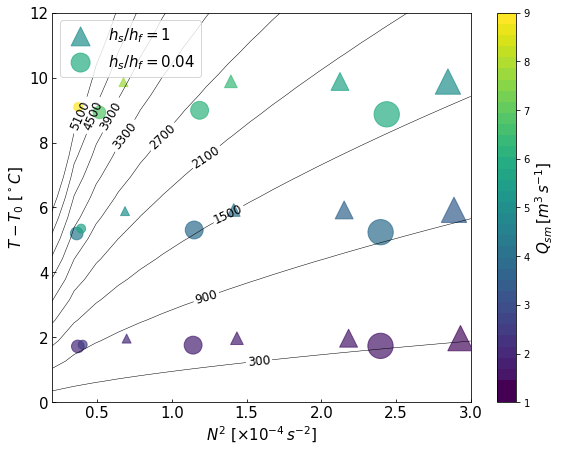

In [10]:
fig2, ax0 =plt.subplots(figsize=(8,6))
fig2.tight_layout() 

import matplotlib as mpl
cmap = mpl.cm.viridis
bounds = np.linspace(1,9,36)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#cqsm = np.arange(3.5,50,2.5)
cqsm = np.linspace(300,5100,9)
cs = ax0.contour(Nsquare*1e4,TF,Qsm2,cqsm,colors='k',linewidths=.5)
plt.clabel(cs, fontsize=12, inline=1)

# Marker size based on initial stratification
volume = np.array([8,4,2,1,0.25])*80


# Qsm = np.concatenate([Qsm_ss, Qsm_ns, Qsm_maxq[:-1], Qsm_minq[:-1]], axis=0)
# min_, max_ = Qsm.min(), Qsm.max()

plt.scatter(N2T10_ns[:-1]*1e4,T10_ns[:-1],s=volume[:-1], c=QsmT10_ns[:-1], cmap=cmap, marker='^',
            norm=norm, alpha=0.7, label='$h_s/h_f=1$')
plt.clim(min_, max_)
plt.scatter(N2T10_mod[:-1]*1e4,T10_ss[:-1],s=volume[:-1], c=QsmT10_ss[:-1], cmap=cmap, marker='o',
            norm=norm, alpha=0.7, label='$h_s/h_f=0.04$')
plt.clim(min_, max_)


plt.scatter(N2T6_ns[:-1]*1e4,T6_ns[:-1],s=volume[:-1], c=QsmT6_ns[:-1], cmap=cmap, marker='^',
            norm=norm, alpha=0.7)
plt.clim(min_, max_)
plt.scatter(N2T6_ss[:-1]*1e4,T6_ss[:-1],s=volume[:-1], c=QsmT6_ss[:-1], cmap=cmap, marker='o',
            norm=norm, alpha=0.7)
plt.clim(min_, max_)


plt.scatter(N2T2_ns[:-1]*1e4,T2_ns[:-1],s=volume[:-1], c=QsmT2_ns[:-1], cmap=cmap, marker='^',
            norm=norm, alpha=0.7)
plt.clim(min_, max_)
plt.scatter(N2T2_ss[:-1]*1e4,T2_ss[:-1],s=volume[:-1], c=QsmT2_ss[:-1], cmap=cmap, marker='o',
            norm=norm, alpha=0.7)
plt.clim(min_, max_)
# plt.annotate('$0.5N^2_0-4N^2_0$', xy=(2.5,10.2), xytext=(.8,10.25),
#             xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)

plt.legend(loc='upper left', fontsize=15)

#plt.ylim([8,11])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks([1,2,3,4,5,6,7,8,9])
cbar.set_label('$Q_{sm}\,[m^3\,s^{-1}]$', fontsize=15)
plt.tick_params(direction='in', labelsize=15)
plt.ylabel(r'$T-T_0$ [$^\circ C$]', size=15)
plt.xlabel(r'$N^2$ [$\times10^{-4}\,s^{-2}$]', size=15)


In [11]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
#fig0.savefig(fig_path + 'Qsm_dependency.png', dpi=300, bbox_inches='tight')
#fig1.savefig(fig_path + 'Qsm_dependency_mod.png', dpi=300, bbox_inches='tight')
fig2.savefig(fig_path + 'Qsm_dependency_ext.png', dpi=300, bbox_inches='tight')

In [73]:
#2*((2e-5)**(-5/8))
np.linspace(1,9,9)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])